In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
def GenerateMat(filename):
    with open('./Data/'+filename) as f:
        content = f.readlines()
    content[0] = int(content[0])
    Mat = np.zeros((content[0],content[0]))
    for i in range(1,len(content)):
        ind = content[i].split()
        Mat[int(ind[0])-1][int(ind[1])-1]=1
        Mat[int(ind[1])-1][int(ind[0])-1]=1
    return Mat
        
        

def Reachable( i , theta_cores , Fuzz_D , visited ):
    #Returns indices of cores(in theta_cores) that are reachable from theta_cores[ i ]
    reach = []
    flag = True
    index = -1
    num_cores = len(theta_cores)
    while(flag):
        if(index == len(reach)):
            flag = False
        if(index == -1):
            flag = False
            for j in range(num_cores):
                if(visited[j] == 0 and i != j):
                    if(Fuzz_D[theta_cores[i]][theta_cores[j]]>0):
                        visited[j] = 1
                        reach.append(j)
                        flag = True
        else:
            for j in range(num_cores):
                if(visited[j] == 0 and index != j):
                    if(Fuzz_D[theta_cores[index]][theta_cores[j]]>0):
                        visited[j] = 1
                        reach.append(j)
                        flag = True
        index += 1
    return np.array(reach)
                
    
def GranEmbed( core , C , Fuzz_D ):
    # Return Normalized Granular Embeddedness of theta-core with community C 
    num = 0
    den = 0
    C = np.array(C)
    C = np.append(C,core)
    n = len(Fuzz_D[0])
    for i in range(n):
        num += np.min(Fuzz_D[C,i])
        den += np.max(Fuzz_D[C,i])
    return float(num)/den

def FuzzyComm( AdjacencyMat , theta , eps , r ):
    '''
    Takes AdjacencyMat(n*n) , theta , eps (epsilon) , and radius(r)
    and returns an n*c matrix where c is the number of communities and the
    i,jth value is the membership of node i in community j
    '''
    theta_cores = []
    num_vertices = AdjacencyMat.shape[0]
    
    #Fuzzy granule initialization
    gran = [ i for i in range(num_vertices) ]
    
    #Calculate distance between all vertices
    G = nx.from_numpy_matrix( AdjacencyMat )
    Dist = nx.all_pairs_shortest_path_length(G)
    
    # Membership values between all nodes
    Fuzz_D = np.zeros( shape = AdjacencyMat.shape ).astype(float)
    for i in range( num_vertices ):
        for j in range( num_vertices ):
            if(Dist[i][j] <= r):
                Fuzz_D[i][j] = 1/float(1 + Dist[i][j])
    Sum = np.sum(Fuzz_D, axis = 1 )
    # Normalization of Membership
    for i in range( num_vertices ):
            Fuzz_D[i] = Fuzz_D[i] / float(Sum[i]) 
    #Theta-cores Finding
    for i in range( num_vertices ):
        if(np.sum(Fuzz_D[:,i]) >= theta):
            theta_cores.append(i)
    theta_cores = np.array(theta_cores)
    num_cores = len( theta_cores )
    Sum = np.sum(Fuzz_D[:, theta_cores ], axis = 1 )
    k = 0
    for i in range(num_vertices):
        Fuzz_D[i] = Fuzz_D[i]/Sum[k]
        k += 1
    #Finding Fuzzy Communities
    Communities = []
    visited = np.zeros( num_cores )
    print('Theta Cores : ',theta_cores)
    for i in range( num_cores ):
        if( visited[i] == 0 ):
            C = []
            C.append(theta_cores[i])
            visited[i] = 1
            Reach = Reachable( i , theta_cores , Fuzz_D , visited.copy() )
            for core_ind in Reach:
                if( GranEmbed( theta_cores[ core_ind ] , C , Fuzz_D ) > eps ):
                    C.append( theta_cores[ core_ind ] )
                    visited[ core_ind ] = 1
            Communities.append( C )
            
#     return Communities
    Communities =  np.array(Communities)
    print(Communities)
    Fuzz_Assoc = np.empty((num_vertices,len(Communities)))
    for i in range(num_vertices):
        for j in range(len(Communities)):
            Fuzz_Assoc[i][j] = np.sum(Fuzz_D[i,Communities[j]])
                
    return Fuzz_Assoc
    
    

In [67]:
Mat = GenerateMat('karate.paj')

In [68]:
Mat

array([[ 0.,  1.,  1., ...,  1.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  1.,  1.],
       [ 0.,  0.,  1., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.]])

In [69]:
theta = 1
eps = 0.5
r = 3
k = FuzzyComm(Mat,theta,eps,r)
k

Theta Cores :  [ 0  1  2  3  7  8  9 13 19 27 28 30 31 32 33]
[[0, 1, 2, 3, 7, 8, 13, 19] [9, 27, 28, 30, 31, 32, 33]]


array([[ 0.64285714,  0.35714286],
       [ 0.63414634,  0.36585366],
       [ 0.59090909,  0.40909091],
       [ 0.64102564,  0.35897436],
       [ 0.60714286,  0.39285714],
       [ 0.60714286,  0.39285714],
       [ 0.60714286,  0.39285714],
       [ 0.64      ,  0.36      ],
       [ 0.56410256,  0.43589744],
       [ 0.47222222,  0.52777778],
       [ 0.60714286,  0.39285714],
       [ 0.60714286,  0.39285714],
       [ 0.62068966,  0.37931034],
       [ 0.61538462,  0.38461538],
       [ 0.46666667,  0.53333333],
       [ 0.46666667,  0.53333333],
       [ 0.89285714,  0.10714286],
       [ 0.61016949,  0.38983051],
       [ 0.46666667,  0.53333333],
       [ 0.59459459,  0.40540541],
       [ 0.46666667,  0.53333333],
       [ 0.61016949,  0.38983051],
       [ 0.46666667,  0.53333333],
       [ 0.4516129 ,  0.5483871 ],
       [ 0.46428571,  0.53571429],
       [ 0.47169811,  0.52830189],
       [ 0.44444444,  0.55555556],
       [ 0.47222222,  0.52777778],
       [ 0.45945946,

In [70]:
G = nx.from_numpy_matrix( Mat )

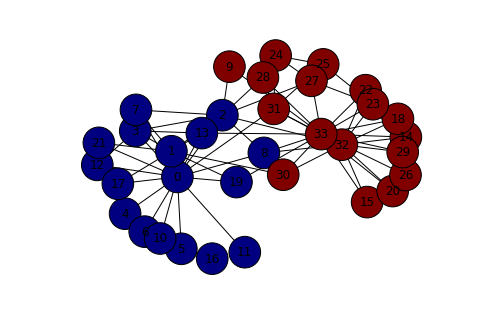

In [71]:
nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = np.argmax(k,axis=1) , node_size=1000, with_labels=True)